In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

sns.set(style='white')
#iris = _sns.load_dataset('iris')

def my_scatter(x,y, **kwargs):
    key_name = kwargs.pop('key_name', None)
    if (x.name == key_name) or (y.name == key_name):
        kwargs['color'] = 'red'
    else: kwargs['color'] = '#1f77b4'
    plt.scatter(x,y, **kwargs)

def my_hist(x, **kwargs):
    key_name = kwargs.pop('key_name', None)
    if (x.name == key_name):
        kwargs['color'] = 'red'
    else: kwargs['color'] = '#1f77b4'
    plt.hist(x, **kwargs)

def my_kde(x,y, **kwargs):
    key_name = kwargs.pop('key_name', None)
    if (x.name == key_name) or (y.name == key_name):
        kwargs['cmap'] = 'Reds_d'
    else: kwargs['cmap'] = 'Blues_d'
    sns.kdeplot(x = x,y = y, **kwargs)

def corrfunc(x, y, **kwargs):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

def annotate_colname(x, **kwargs):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

def annotate_colname(x, **kwargs):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

def cor_matrix(df, as_returns = False, fname = None, key_name = None):
  if as_returns == True:
      df = df.select_dtypes(include=numerics)
      df = df.pct_change(1)
      df = df.dropna()
  g = sns.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
  g.map_upper(my_scatter, key_name = key_name)
  g.map_diag(my_hist, key_name = key_name)
  g.map_diag(annotate_colname)
  g.map_lower(my_kde, key_name = key_name)
  g.map_lower(corrfunc)
  # Remove axis labels, as they're in the diagonals.
  for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
  if fname is not None:
      plt.savefig(fname, dpi=600, bbox_inches='tight')
  plt.show()
  return g

In [3]:
def parse_dat(file):
    """
    parses the results csv, named as results_[day].csv
    """
    day_lookup = r"(?<=_)(.*)(?=\.)"
    day = re.findall(day_lookup,file)[0]
    #print(fname)
    df = pd.read_csv(file, index_col=False, sep=";")
    return day,  df

In [4]:
output_dfs = {}
mypath = os.getcwd()
print(mypath)
for afile in glob.glob(mypath +'/*.csv', recursive=True):
    name, output = parse_dat(afile)
    #create unique list of names
    products = output['product'].unique()
    #create a data frame dictionary to store your data frames
    dfs = {elem : pd.DataFrame() for elem in products}
    for key in dfs.keys():
        dfs[key] = output[:][output["product"] == key]
    print(dfs)
    output_dfs[name]=dfs

C:\Users\tommy\OneDrive - University of Cambridge\Trading\Competitions\IMC_Prosperity\Data_analysis
{'PEARLS':        day  timestamp product  bid_price_1  bid_volume_1  bid_price_2  \
0       -1          0  PEARLS        10002             1       9996.0   
2       -1        100  PEARLS         9996             2       9995.0   
5       -1        200  PEARLS         9995            20          NaN   
6       -1        300  PEARLS         9996             2       9995.0   
8       -1        400  PEARLS         9996             2       9995.0   
...    ...        ...     ...          ...           ...          ...   
19991   -1     999500  PEARLS        10000             5       9996.0   
19992   -1     999600  PEARLS        10000             4       9996.0   
19995   -1     999700  PEARLS         9995            26          NaN   
19997   -1     999800  PEARLS         9995            20          NaN   
19999   -1     999900  PEARLS         9996             2       9995.0   

       bid_v

In [5]:
def orderbook_fv(data, a,b,c):
    fv = []
    for i, *row in data.itertuples():
        if not np.isnan(row[13]):
            weighted_asks = (a*row[9]+b*row[11]+c*row[13])/(a+b+c)
        elif not np.isnan(row[11]):
            weighted_asks = (a*row[9]+b*row[11])/(a+b)
        else:
            weighted_asks = (a*row[9])/(a)

        if not np.isnan(row[7]):
            weighted_bids = (a*row[3]+b*row[5]+c*row[7])/(a+b+c)
        elif not np.isnan(row[5]):
            weighted_bids = (a*row[3]+b*row[5])/(a+b)
        else:
            weighted_bids = (a*row[3])/(a)
        fv.append((weighted_asks+weighted_bids)/2)
    return fv

In [6]:
def orderbook_vol_fv(data, a,b,c):
    fv = []
    for i, *row in data.itertuples():
        #print(row)
        if not np.isnan(row[13]):
            weighted_asks = (a*row[9]/row[10]+b*row[11]/row[12]+c*row[13]/row[14])/(a/row[10]+b/row[12]+c/row[14])
        elif not np.isnan(row[11]):
            weighted_asks = (a*row[9]/row[10]+b*row[11]/row[12])/(a/row[10]+b/row[12])
        else:
            weighted_asks = (a*row[9]/row[10])/(a/row[10])

        if not np.isnan(row[7]):
            weighted_bids = (a*row[3]/row[4]+b*row[5]/row[6]+c*row[7]/row[8])/(a/row[4]+b/row[6]+c/row[8])
        elif not np.isnan(row[5]):
            weighted_bids = (a*row[3]/row[4]+b*row[5]/row[6])/(a/row[4]+b/row[6])
        else:
            weighted_bids = (a*row[3]/row[4])/(a/row[4])
        fv.append((weighted_asks+weighted_bids)/2)
        #print((weighted_asks,weighted_bids))
    return fv

count    9999.000000
mean       -0.005651
std         1.673186
min        -6.500000
25%        -1.000000
50%         0.000000
75%         1.000000
max         6.500000
Name: change, dtype: float64


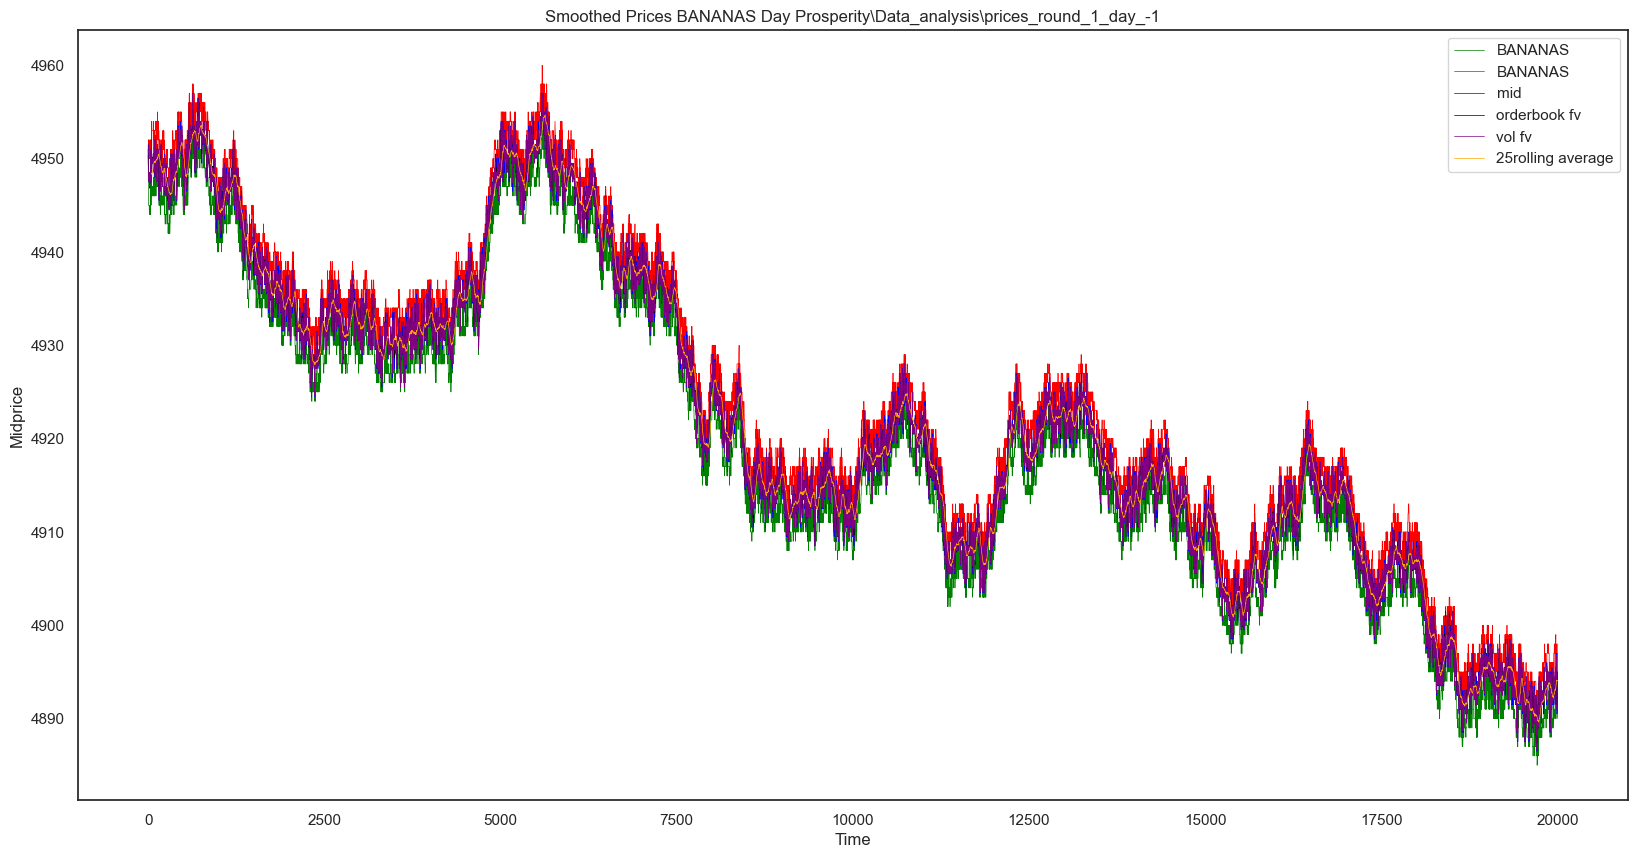

count    9999.000000
mean       -0.005151
std         1.695162
min        -7.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         6.500000
Name: change, dtype: float64


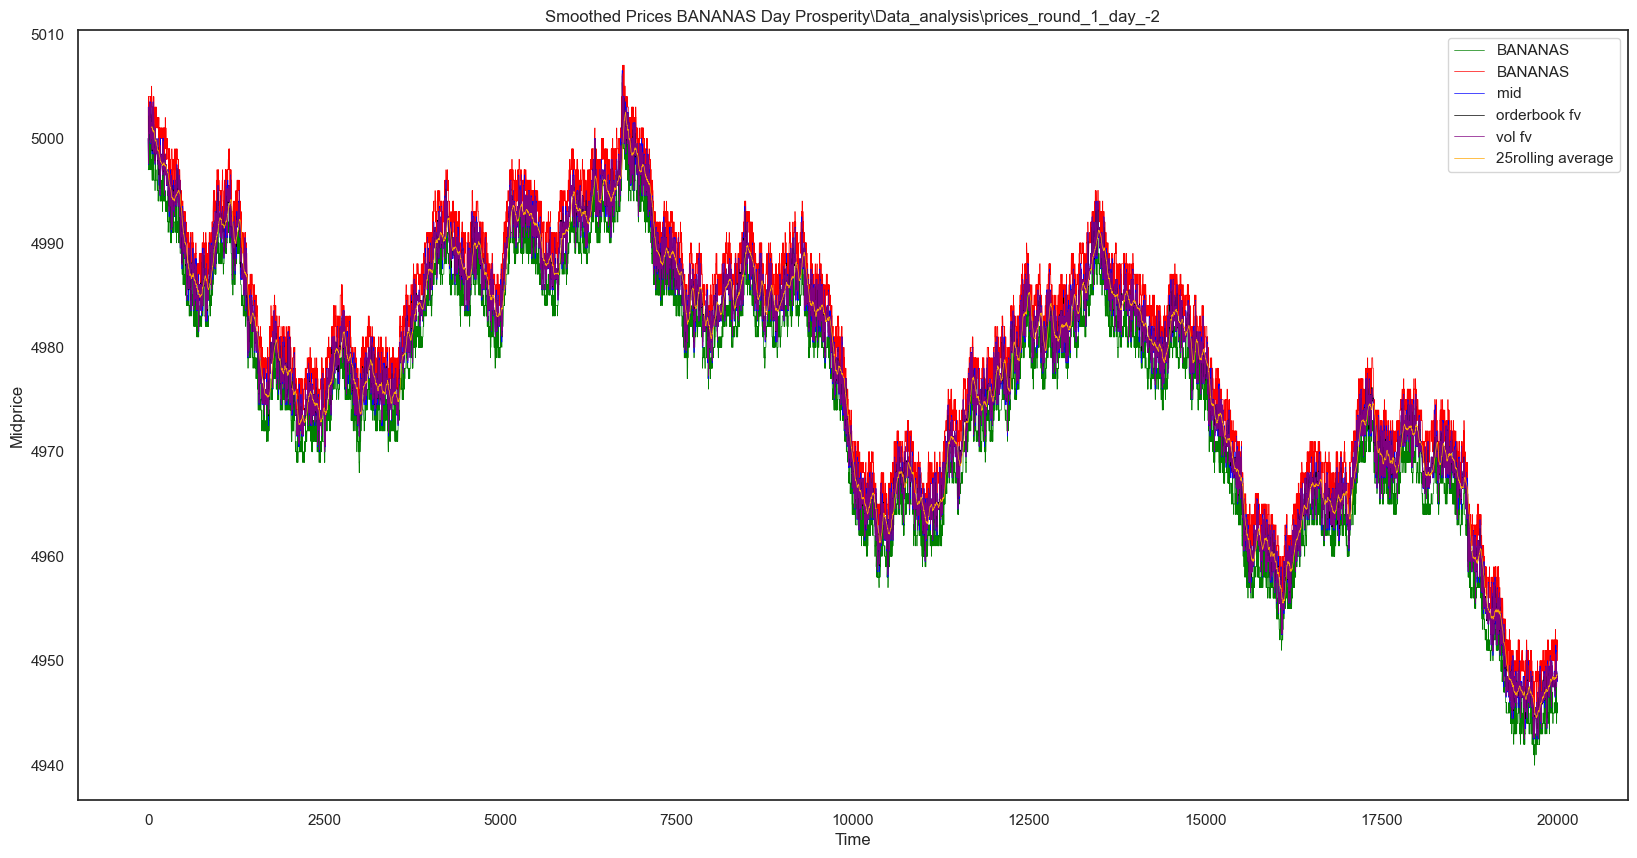

count    9999.00000
mean       -0.00230
std         1.65033
min        -7.00000
25%        -1.00000
50%         0.00000
75%         1.00000
max         6.50000
Name: change, dtype: float64


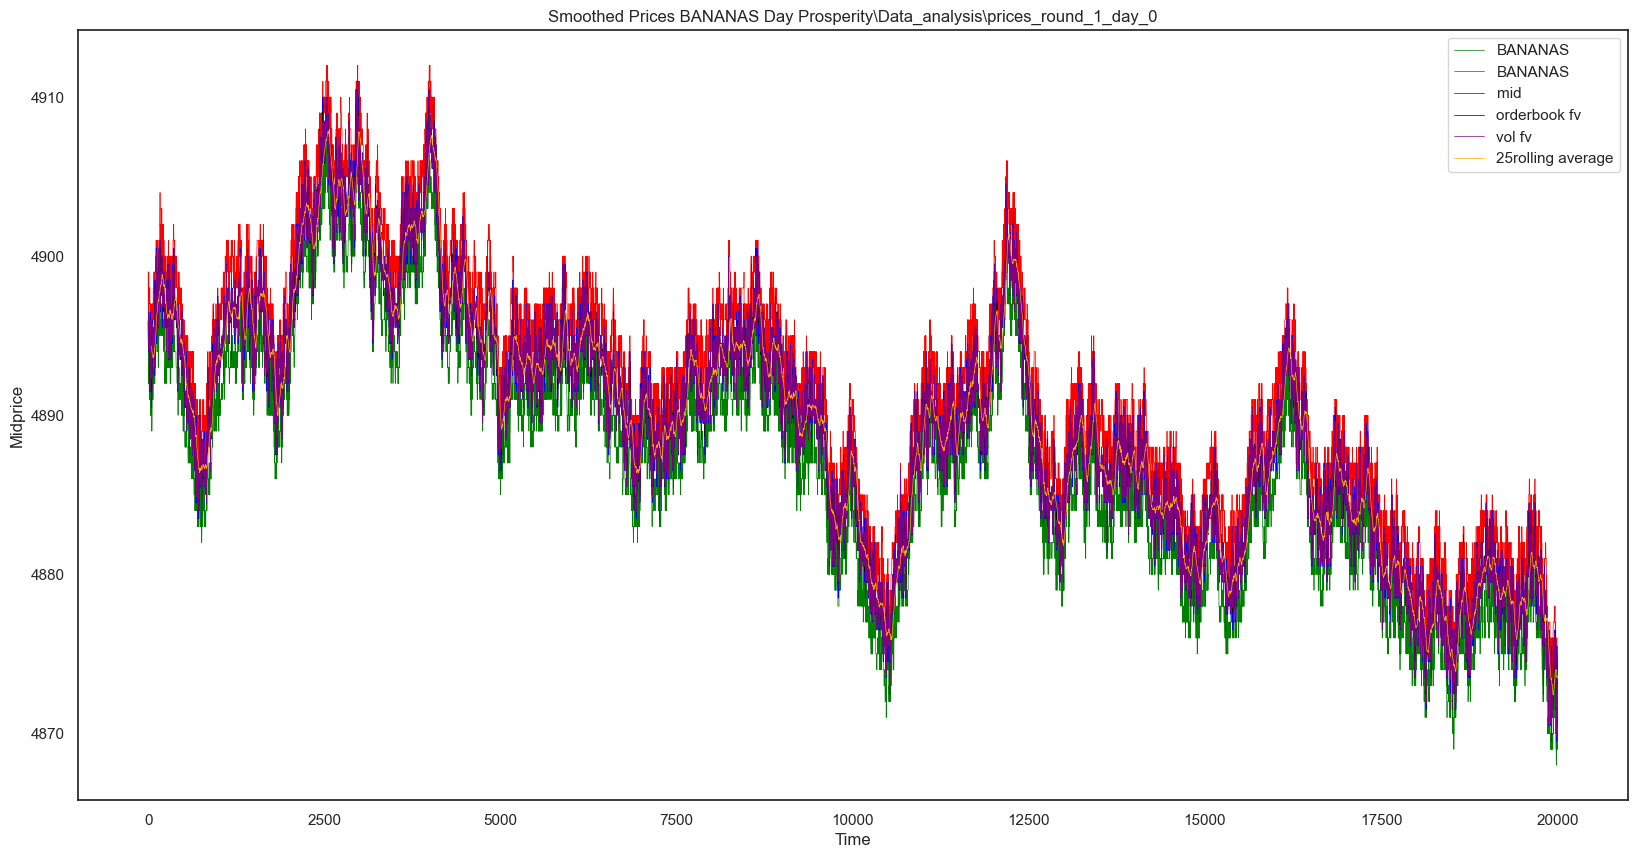

In [11]:
# orderbook fv
for day, assets in output_dfs.items():
    for asset, data in assets.items():
        if asset == 'BANANAS':
            periods = 25
            data.loc[:,'FV'] = orderbook_fv(data, 1, 0.5, 0.25)
            data.loc[:,'FV_vol'] = orderbook_vol_fv(data, 1, 0.5, 0.25)
            data.loc[:, 'MA25'] = data['mid_price'].rolling(window=periods).mean()
            data.loc[:, 'T-1'] = data['mid_price'].shift(periods=1)
            data.loc[:, 'change'] = data['mid_price']-data['T-1']
            #print(data)
            print(data['change'].describe())
#             for i in np.arange(0,950000, 50000):
#                 mask = ((data['timestamp'] >= i) & (data['timestamp'] <=i+5000))

#             mask = ((data['timestamp'] >= 0) & (data['timestamp'] <=10000))
#             data1 = data.loc[mask, :]
            data1 = data.copy()

            #print(data)

            mid = data1['mid_price']
            best_bid = data1['bid_price_1']
            best_ask = data1['ask_price_1']
            mid_average = data1['MA25']
            
            plt.plot(best_bid, label = asset, linewidth = 0.5, color = 'green')
            plt.plot(best_ask , label = asset, linewidth = 0.5, color = 'red')
            plt.plot(mid , label = "mid", linewidth = 0.5, color = "blue")
            plt.plot(data1['FV'] , label = "orderbook fv", linewidth = 0.5, color = "black")
            plt.plot(data1['FV_vol'] , label = "vol fv", linewidth = 0.5, color = "purple")
            plt.plot(mid_average , label = str(periods)+"rolling average", linewidth = 0.5, color = "orange")
            #for i, *row in data1.itertuples():   
                #check for large change 
#                 if row[21] >= 2 or row[21] <= -2:
#                     #print(row, row[21])
#                     plt.plot(i,row[15], 'ro')
            plt.xlabel('Time')
            plt.ylabel('Midprice')
            plt.legend()
            plt.title("Smoothed Prices " + asset + " Day " + day)
            plt.show()

    

0        2
24       3
26       2
37       2
40       2
        ..
19901    3
19934    3
19949    3
19960    3
19973    2
Name: spread, Length: 1598, dtype: int64
count    1598.000000
mean        2.342929
std         0.474836
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: spread, dtype: float64
Change count    9999.000000
mean       -0.000300
std         2.080605
min        -7.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: change, dtype: float64
Bid count    10000.00000
mean      9996.57840
std          1.90547
min       9995.00000
25%       9995.00000
50%       9996.00000
75%       9996.00000
max      10002.00000
Name: bid_price_1, dtype: float64
Ask count    10000.00000
mean     10003.39440
std          1.94284
min       9998.00000
25%      10004.00000
50%      10004.00000
75%      10005.00000
max      10005.00000
Name: ask_price_1, dtype: float64
Spread: count    10000.00

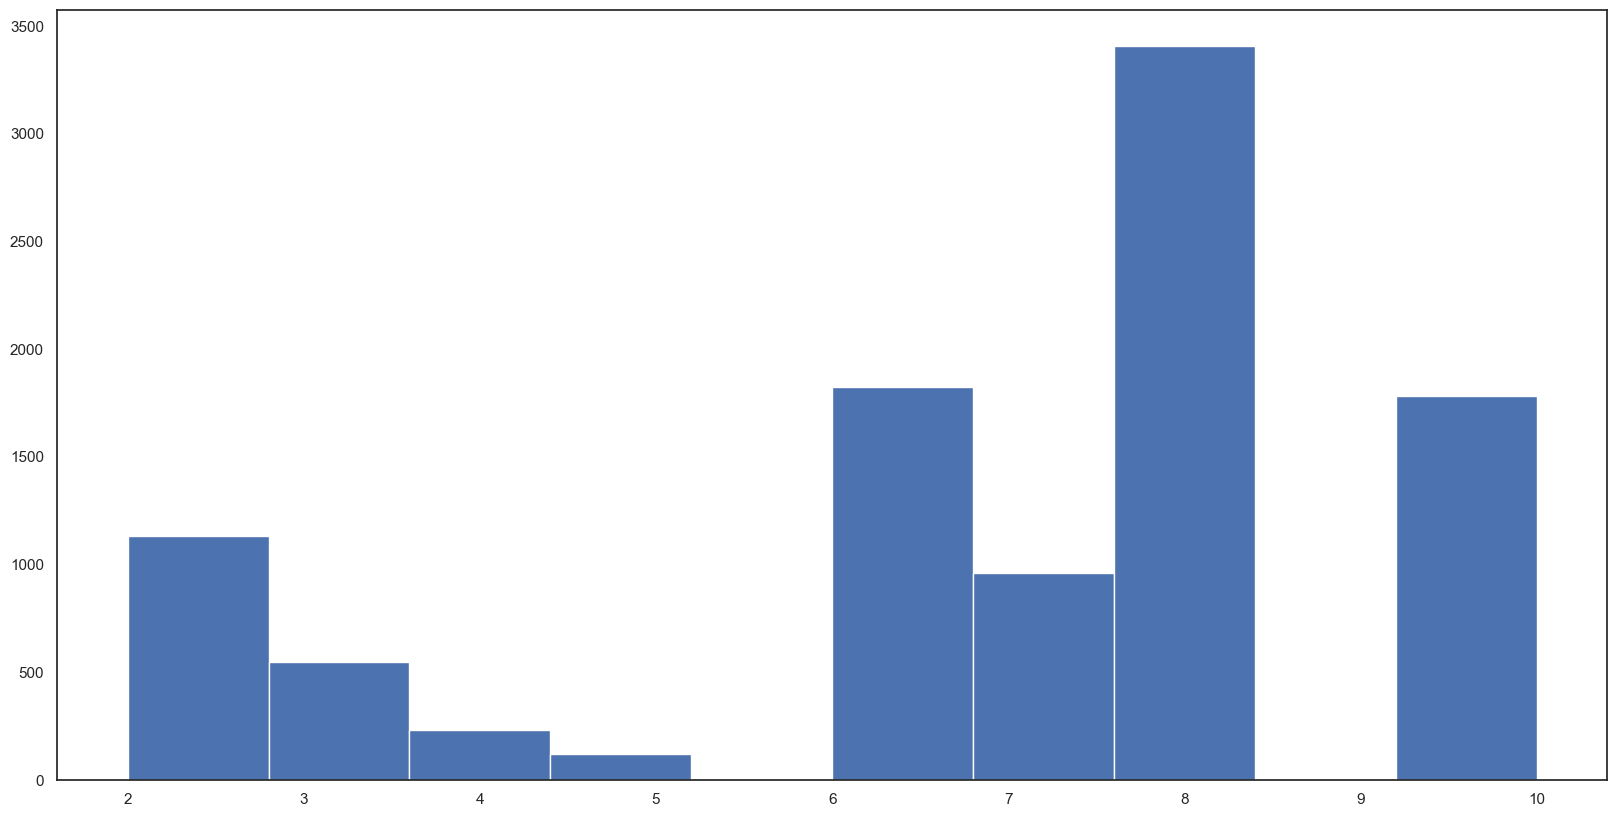

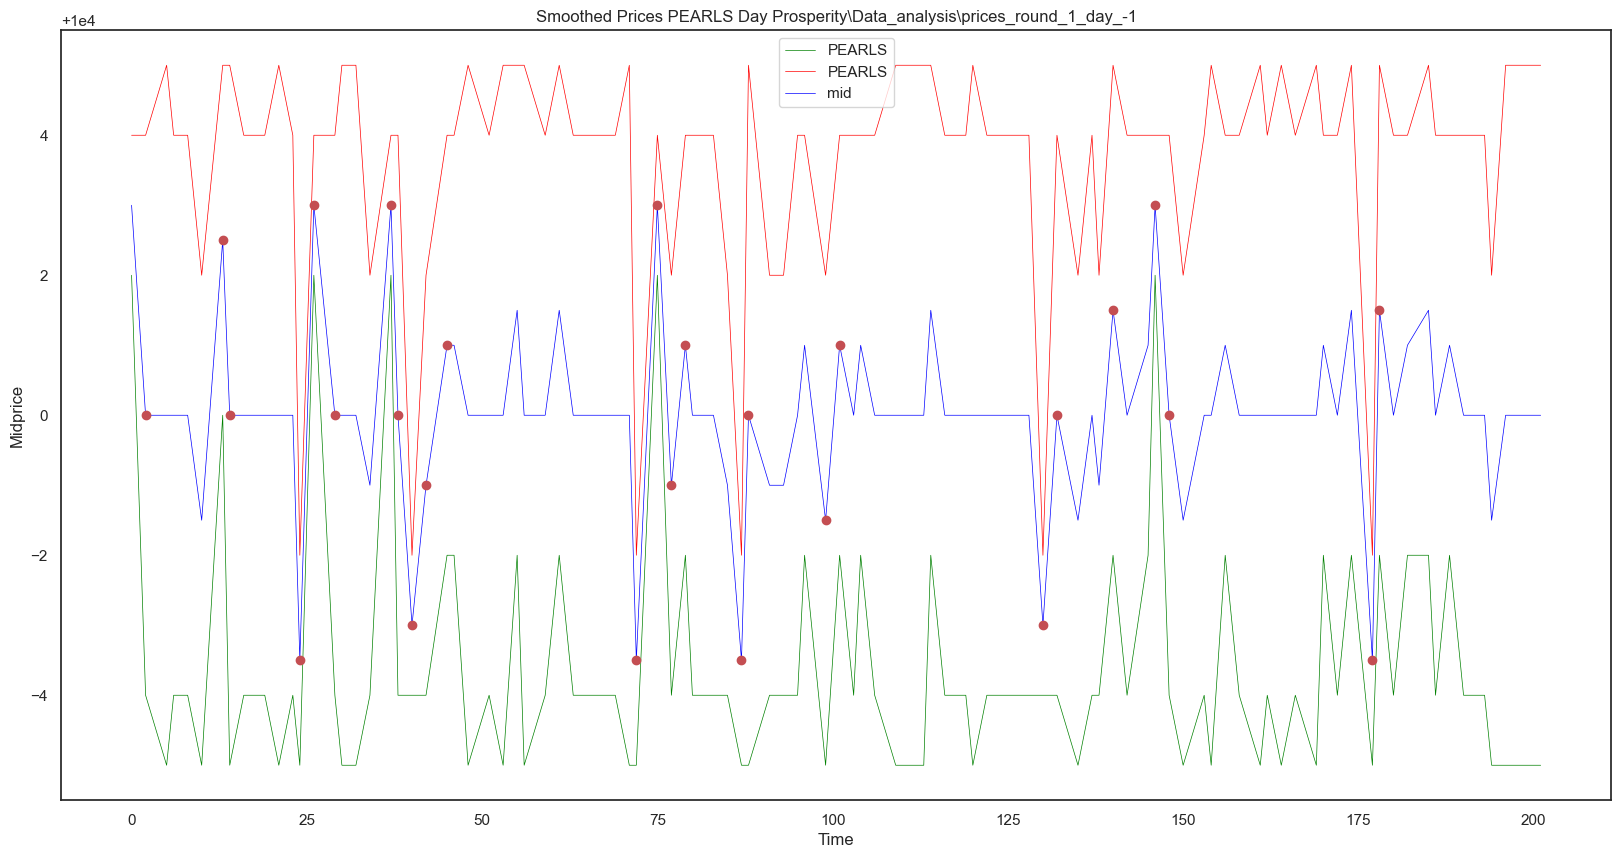

8        3
21       2
29       3
45       2
50       3
        ..
19909    2
19925    2
19938    3
19953    3
19997    2
Name: spread, Length: 1712, dtype: int64
count    1712.000000
mean        2.328855
std         0.469934
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: spread, dtype: float64
Change count    9999.000000
mean        0.000000
std         2.131516
min        -7.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: change, dtype: float64
Bid count    10000.000000
mean      9996.639100
std          1.968207
min       9995.000000
25%       9995.000000
50%       9996.000000
75%       9998.000000
max      10002.000000
Name: bid_price_1, dtype: float64
Ask count    10000.000000
mean     10003.367900
std          1.963806
min       9998.000000
25%      10002.000000
50%      10004.000000
75%      10005.000000
max      10005.000000
Name: ask_price_1, dtype: float64
Spread: c

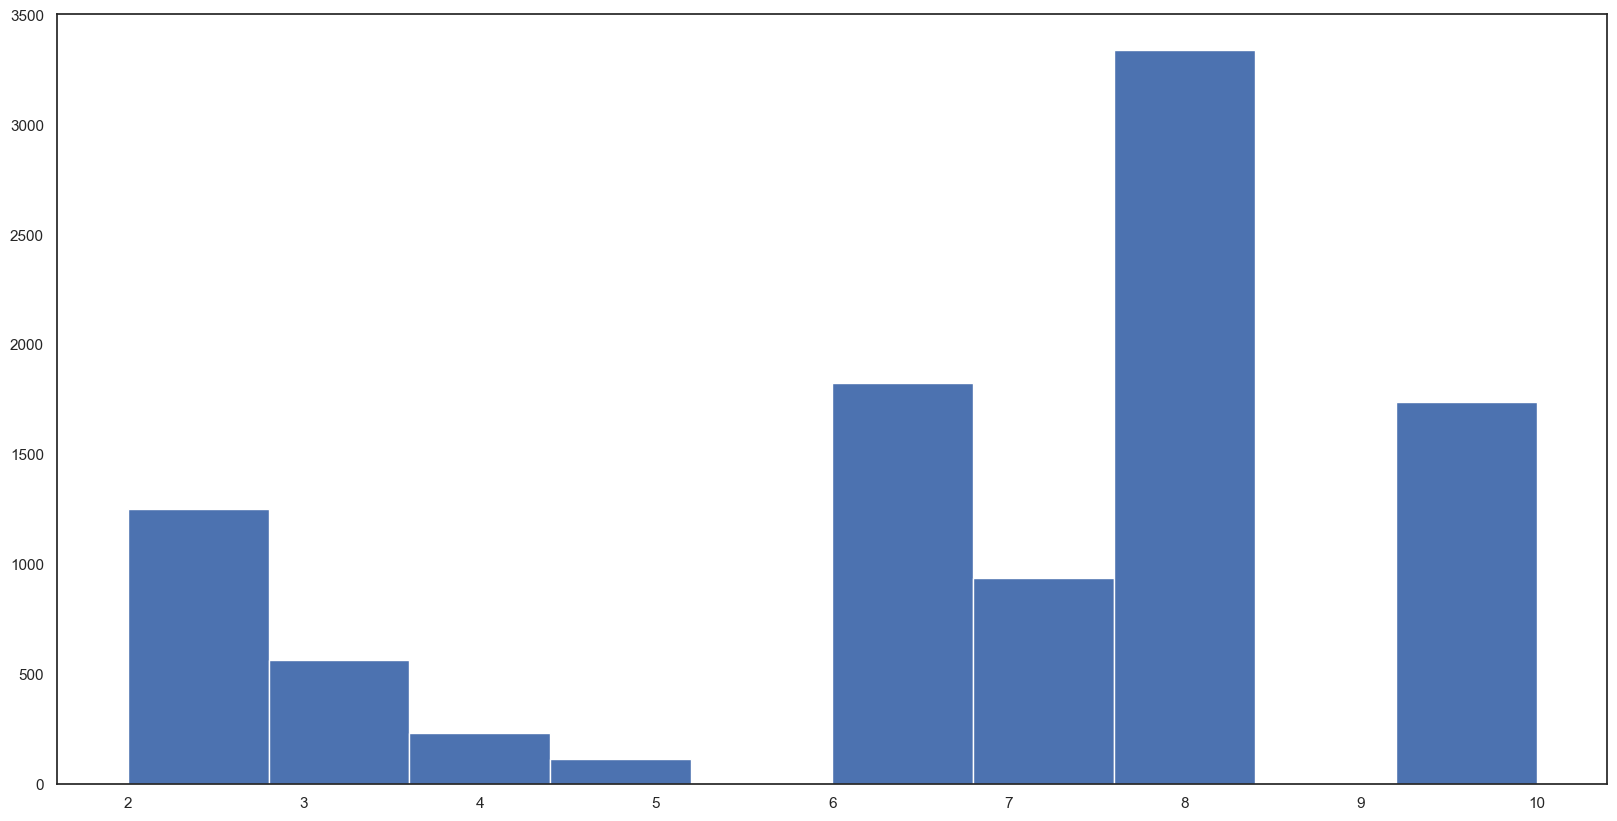

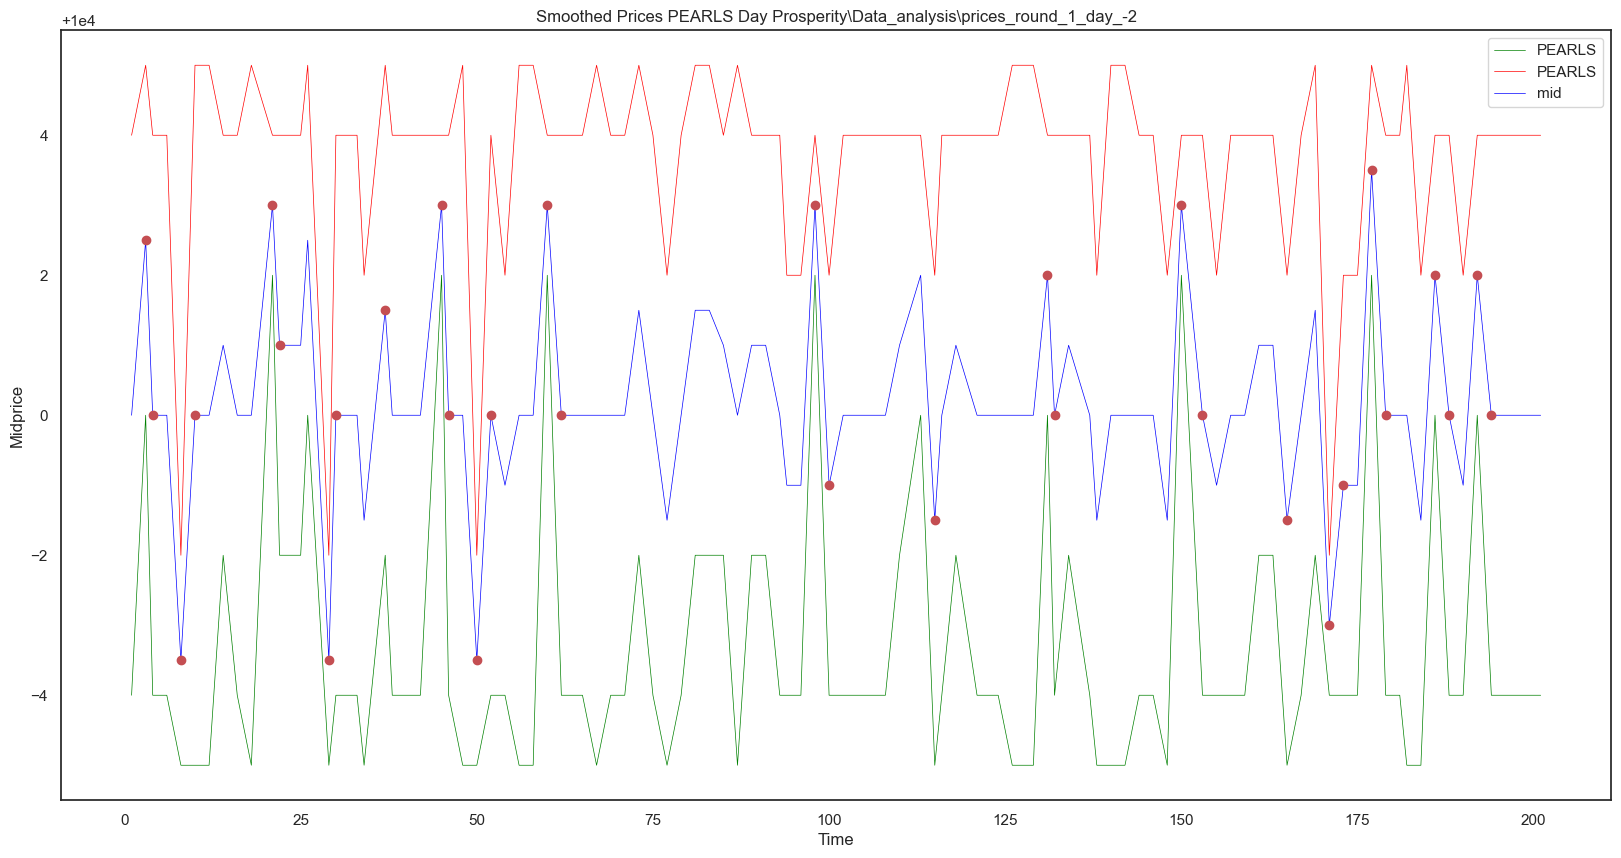

6        2
10       2
31       2
58       2
72       3
        ..
19954    2
19964    2
19968    3
19976    3
19980    3
Name: spread, Length: 1656, dtype: int64
count    1656.000000
mean        2.357488
std         0.479405
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: spread, dtype: float64
Change count    9999.000000
mean       -0.000150
std         2.124224
min        -7.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: change, dtype: float64
Bid count    10000.000000
mean      9996.611400
std          1.939115
min       9995.000000
25%       9995.000000
50%       9996.000000
75%       9996.000000
max      10002.000000
Name: bid_price_1, dtype: float64
Ask count    10000.000000
mean     10003.388100
std          1.941457
min       9998.000000
25%      10004.000000
50%      10004.000000
75%      10005.000000
max      10005.000000
Name: ask_price_1, dtype: float64
Spread: c

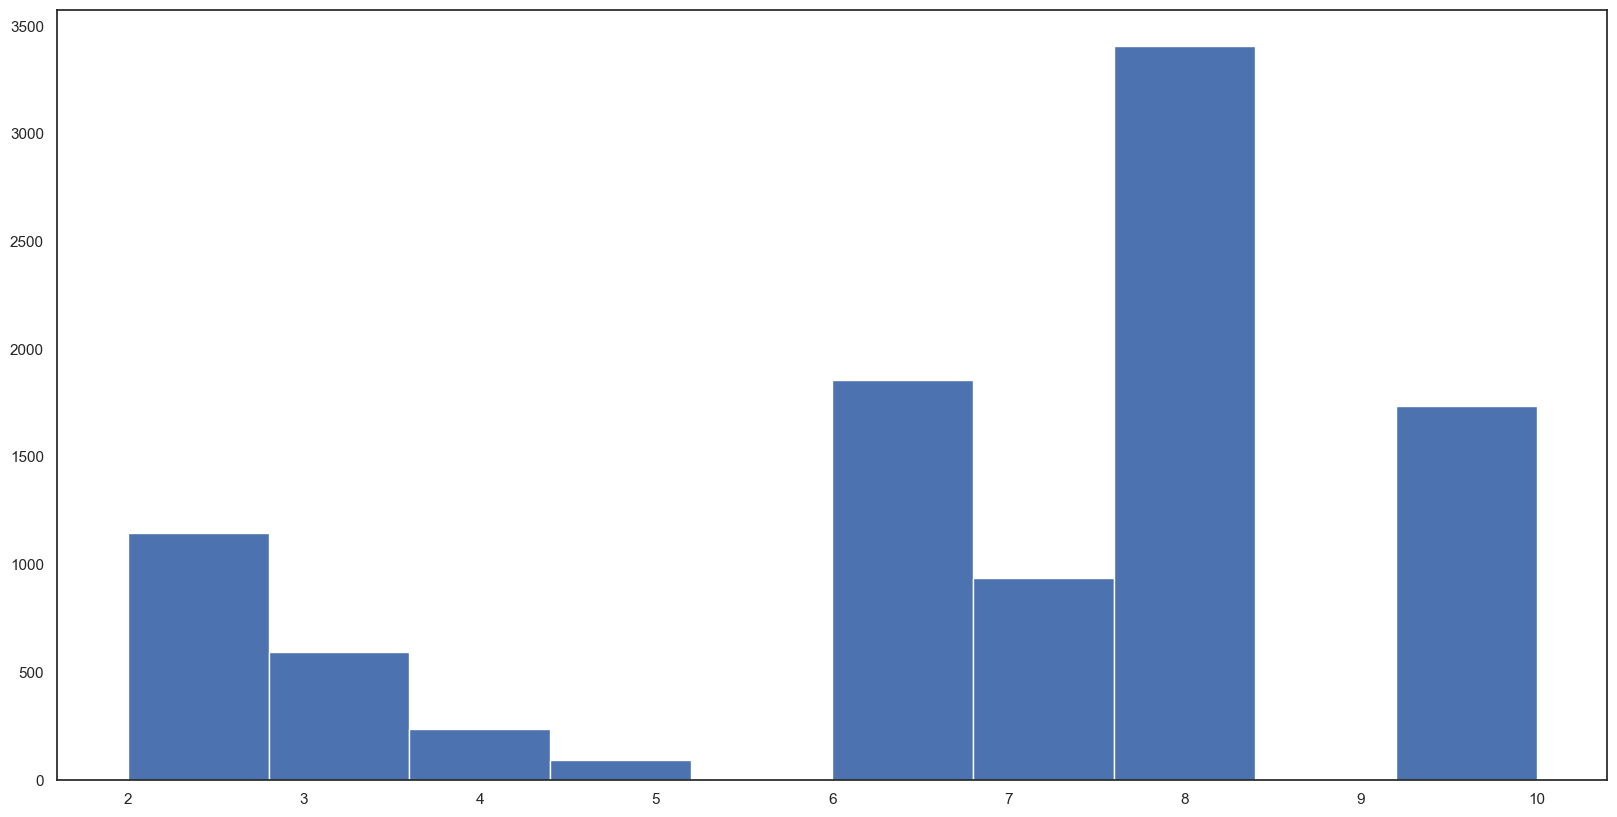

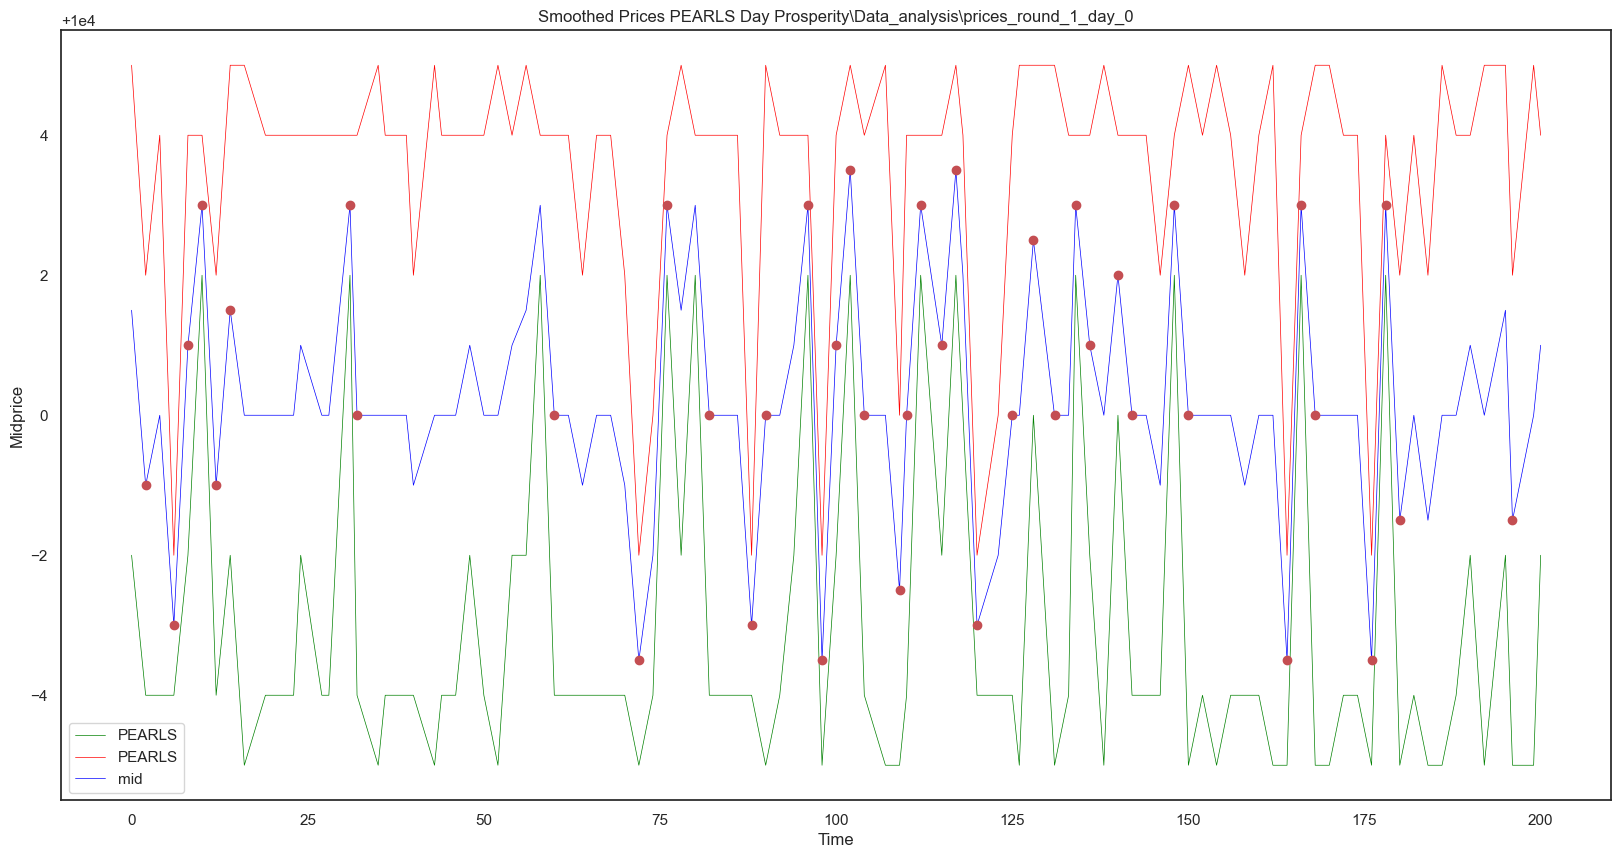

In [8]:
# orderbook fv
for day, assets in output_dfs.items():
    for asset, data in assets.items():
        if asset == 'PEARLS':
            data.loc[:, 'T-1'] = data['mid_price'].shift(periods=1)
            data.loc[:, 'change'] = data['mid_price']-data['T-1']
            data.loc[:, 'spread'] = data['ask_price_1']-data['bid_price_1']
            mask2 = ((data['ask_price_1'] < 10000) | (data['bid_price_1'] > 10000))
            print(data.loc[mask2, 'spread'])
            print(data.loc[mask2, 'spread'].describe())
            print('Change', data['change'].describe())
            print('Bid', data['bid_price_1'].describe())
            print('Ask', data['ask_price_1'].describe())
            print('Spread:', data['spread'].describe())
            #fig, ax = plt.subplots()
            #data['spread'].value_counts().plot(ax=ax, kind='bar', xlabel='numbers', ylabel='frequency')
            plt.hist(data['spread'])
            plt.show()
#             for i in np.arange(0,950000, 50000):
#                 mask = ((data['timestamp'] >= i) & (data['timestamp'] <=i+5000))
            mask = ((data['timestamp'] >= 0) & (data['timestamp'] <=10000))
            data1 = data.loc[mask, :]
            #print(data)

            mid = data1['mid_price']
            best_bid = data1['bid_price_1']
            best_ask = data1['ask_price_1']
            
            plt.plot(best_bid, label = asset, linewidth = 0.5, color = 'green')
            plt.plot(best_ask , label = asset, linewidth = 0.5, color = 'red')
            plt.plot(mid , label = "mid", linewidth = 0.5, color = "blue")
            for i, *row in data1.itertuples():
                #print(row)
                #check for large change 
                if row[18] >= 2 or row[18] <= -2:
                    #print(row, row[21])
                    plt.plot(i,row[15], 'ro')
            plt.xlabel('Time')
            plt.ylabel('Midprice')
            plt.legend()
            plt.title("Smoothed Prices " + asset + " Day " + day)
            plt.show()

    

In [9]:
#output_dfs.items()['Prosperity\\Data_analysis\\prices_round_1_day_-1']
output_dfs.items()

dict_items([('Prosperity\\Data_analysis\\prices_round_1_day_-1', {'PEARLS':        day  timestamp product  bid_price_1  bid_volume_1  bid_price_2  \
0       -1          0  PEARLS        10002             1       9996.0   
2       -1        100  PEARLS         9996             2       9995.0   
5       -1        200  PEARLS         9995            20          NaN   
6       -1        300  PEARLS         9996             2       9995.0   
8       -1        400  PEARLS         9996             2       9995.0   
...    ...        ...     ...          ...           ...          ...   
19991   -1     999500  PEARLS        10000             5       9996.0   
19992   -1     999600  PEARLS        10000             4       9996.0   
19995   -1     999700  PEARLS         9995            26          NaN   
19997   -1     999800  PEARLS         9995            20          NaN   
19999   -1     999900  PEARLS         9996             2       9995.0   

       bid_volume_2  bid_price_3  bid_volume_3 